# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [11]:
print(os.getcwd())
file = 'toy_example_mdn_05_04_no_ratio'



os.chdir('/home/ubuntu/results/{}'.format(file))

/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [12]:
list_collection_inc = torch.load('list_collection_inc.pt')
list_collection = torch.load('list_collection.pt')

In [13]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.062
acceptance rate:  0.06881818181818182
acceptance rate:  0.07014285714285715


/home/ubuntu/pyknos/pyknos/mdn/mdn.py:288: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  chosen_precision_factors,


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.078
acceptance rate:  0.07363636363636364
acceptance rate:  0.07376190476190476
tensor([ 5.1504,  8.0642,  8.6846,  5.7925,  8.8847, 12.8332, 10.8671,  8.0578,
         6.5801, 11.6294,  3.5815,  6.6813,  7.4292, 10.8090,  7.4751])
tensor([ 9.0018, 25.1792, 23.3537, 15.8769, 66.8570, 49.5950, 35.9555, 35.4184,
        11.8786, 65.6434,  4.4428, 59.6649, 95.8679, 17.2034, 49.3286])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 29.1348, 213.8488,  40.6735,  31.7887, 304.5841,  93.9004,  96.2616,
          65.3124,  50.3009,  74.1584,   4.7929,  39.9879,  29.9963, 315.3782,
          34.7956]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.064
acceptance rate:  0.0679090909090909
acceptance rate:  0.06923809523809524


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.066
acceptance rate:  0.07254545454545455
acceptance rate:  0.06961904761904762
tensor([3.0529, 2.0023, 6.4011, 2.2955, 7.5447, 4.1736, 5.8059, 3.8569, 2.8069,
        2.2828, 4.0719, 7.5138, 1.9033, 5.7223, 7.3855])
tensor([ 8.4460,  3.9671, 21.8265,  9.9638, 78.6126, 57.7127, 30.5655, 28.5484,
         4.5874, 70.5967,  6.2071, 77.3056, 96.6562, 48.0114, 36.3990])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.8734,  2.8767, 19.7986,  1.3043, 90.7771, 10.4600, 20.9514,  6.7866,
          2.5798,  1.4582,  7.1145, 89.6206,  3.4145, 46.2195, 61.7623]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.613
acceptance rate:  0.6105454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.619
acceptance rate:  0.6204545454545455
tensor([0.3938, 0.9100, 1.0874, 0.8708, 1.4030, 1.0794, 0.6912, 1.1102, 1.1434,
        1.8436, 1.4060, 2.2089, 1.3269, 2.9291, 1.3786])
tensor([ 3.2795,  4.3530, 21.1085,  8.5322, 92.5063, 57.9189, 24.3191, 25.7592,
         3.7248, 67.4422,  3.2647, 61.9504, 97.7661, 40.7931, 47.2038])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.5485, 1.3647, 0.6218, 1.0947, 3.2864, 4.2660, 3.7017, 0.7815, 0.0575,
         3.8589, 1.6534, 9.3468, 0.8587, 3.0295, 2.5576]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.888
acceptance rate:  0.8783636363636363


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.898
acceptance rate:  0.884
tensor([1.0509, 3.6966, 1.9904, 5.0869, 1.8993, 4.0863, 2.8731, 3.4732, 2.0476,
        3.6168, 2.8569, 2.1495, 2.9591, 2.2724, 3.5054])
tensor([ 3.9940,  9.6876, 23.3558, 13.4142, 96.4653, 53.3301, 24.7608, 27.0128,
         9.0219, 71.0496, 12.7374, 63.5330, 92.5885, 43.9550, 48.0695])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.4966, 11.8240,  6.4231, 16.6401, 21.5623,  7.8358,  5.0789,  4.2867,
         13.4893,  5.3057, 32.4649,  4.0879, 23.3471,  9.0820,  9.1004]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.162
acceptance rate:  0.14427272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.133
acceptance rate:  0.14327272727272727
tensor([0.9925, 0.7612, 0.4789, 0.3690, 0.7035, 0.8976, 0.5526, 0.7646, 0.5925,
        0.6905, 0.4361, 0.7919, 0.3672, 0.1772, 1.0550])
tensor([ 2.9141,  5.4146, 19.9996,  9.0949, 92.1523, 56.8866, 25.0072, 27.7057,
         4.8918, 68.7097,  4.2776, 63.4812, 99.4820, 39.5612, 45.6492])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0037, 0.2339, 0.3509, 0.9745, 2.4153, 1.7905, 2.2313, 0.3097, 0.5966,
         0.9412, 0.6860, 3.2191, 0.6855, 1.3424, 0.2137]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.213
acceptance rate:  0.21163636363636365


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.197
acceptance rate:  0.21809090909090909
tensor([1.5425, 1.9329, 2.1482, 3.6388, 0.9453, 0.7532, 1.3053, 2.4796, 0.9044,
        1.6146, 3.3480, 2.1559, 0.5768, 1.5385, 2.2457])
tensor([ 3.4492,  4.3758, 19.7293, 10.8699, 90.6001, 56.2228, 25.6529, 27.6489,
         5.8313, 69.4699,  6.0403, 64.6436, 99.2472, 39.7224, 46.0558])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.3571, 2.0280, 1.0794, 5.2070, 0.1831, 0.8148, 0.9928, 1.8766, 1.6864,
         0.4648, 4.4373, 1.9756, 0.2471, 0.2912, 1.7700]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.899
acceptance rate:  0.8939090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.903
acceptance rate:  0.8907272727272727
tensor([11.7396, 11.6628,  9.0140, 10.8899,  4.8444,  5.0136,  9.9127,  8.3032,
         5.0242,  4.7410,  7.4613,  8.4041,  8.5920,  9.6627,  7.9391])
tensor([46.7043, 36.4059, 22.5792, 25.1080, 79.0773, 62.1020, 78.6190, 25.0918,
        34.3381, 67.2079, 21.9369, 72.4155, 82.2783, 40.1323, 66.6191])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1020.9796,  527.3119,   41.2536,  170.5333,   69.3092,   35.6750,
         1378.5955,   33.6756,  470.7072,   13.0800,  168.7557,   53.2648,
          174.0686,   43.9247,  262.6354]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.081
acceptance rate:  0.08127272727272727
acceptance rate:  0.08042857142857143


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.075
acceptance rate:  0.08427272727272728
acceptance rate:  0.08395238095238096
tensor([1.2560, 2.2862, 4.3616, 5.2080, 3.3424, 5.6368, 9.8645, 5.6093, 1.2423,
        5.9721, 1.9737, 4.3485, 2.0015, 1.5796, 6.4909])
tensor([ 2.7148,  4.1514, 21.3464, 12.5244, 89.0060, 52.8108, 27.9161, 29.7485,
         6.8613, 74.6312,  4.2211, 63.8800, 96.8558, 38.8950, 39.9780])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1015,  2.9951,  8.4452, 14.5976,  4.3731, 16.0539, 46.2852, 17.2847,
          4.1481, 26.2699,  1.0712,  9.7324,  3.1080,  0.9008, 31.3056]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.519
acceptance rate:  0.49372727272727274


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.511
acceptance rate:  0.49454545454545457
tensor([4.2198, 9.6883, 4.4184, 4.6231, 5.2606, 6.9180, 6.1317, 3.9609, 1.9398,
        2.9215, 9.1156, 2.8160, 3.2710, 4.3935, 3.5461])
tensor([ 8.8442, 29.4211, 28.2587, 11.8584, 90.4145, 35.6129, 13.3149, 18.7537,
         4.5019, 73.9205, 30.2483, 66.5821, 95.2314, 43.6879, 47.6789])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 24.0407, 318.4342,  41.8787,  10.3823,  11.7628, 209.4243, 110.1265,
          39.9686,   0.8447,  10.3807, 357.5749,   2.5991,  10.7656,  14.4718,
           8.1098]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.828
acceptance rate:  0.8324545454545454


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.841
acceptance rate:  0.8436363636363636
tensor([4.4225, 1.0111, 2.5613, 2.0581, 2.1158, 1.5096, 3.7854, 0.6261, 1.0899,
        2.2125, 2.1227, 1.3224, 1.9218, 1.3056, 2.1734])
tensor([ 9.6579,  4.1487, 23.3555, 11.5280, 92.7980, 53.7614, 21.2931, 27.3216,
         5.2296, 65.3604,  9.9551, 62.0548, 96.5963, 36.3899, 47.7843])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[29.9561,  1.7138,  7.4693,  2.0636,  4.9033,  0.9947, 21.6176,  0.2160,
          0.7638, 11.9163, 13.2769,  7.8770,  3.5824,  6.6019,  4.9615]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.425
acceptance rate:  0.4167272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.408
acceptance rate:  0.4148181818181818
tensor([1.0177, 0.6161, 0.4844, 0.5442, 0.9207, 1.0999, 0.7909, 1.1877, 1.3398,
        0.8503, 0.4093, 0.4100, 0.2506, 1.0498, 1.6178])
tensor([ 3.0251,  4.0859, 20.0317,  9.6988, 91.2980, 56.2907, 25.3371, 26.6774,
         5.4721, 69.0198,  4.6608, 64.1782, 99.6961, 39.8400, 45.3254])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.2674e-04, 2.0060e+00, 3.4260e-01, 3.0191e-01, 8.4890e-01, 8.4261e-01,
         1.4300e+00, 8.5331e-02, 1.1885e+00, 5.0411e-01, 5.3470e-01, 2.1350e+00,
         1.1577e+00, 1.5230e-02, 3.8049e-01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.764
acceptance rate:  0.757090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.78
acceptance rate:  0.7521818181818182
tensor([0.3243, 0.2801, 0.2959, 0.3636, 0.5806, 0.3227, 0.3090, 0.2604, 0.4082,
        0.3060, 0.4640, 0.3330, 0.6946, 0.4562, 0.5127])
tensor([ 3.5486,  4.5286, 19.9984,  9.8162, 90.3518, 55.9199, 25.5009, 26.8719,
         5.5585, 69.4300,  5.0080, 64.4455, 99.2535, 39.6836, 44.7589])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.8291, 1.8945, 0.7616, 0.5947, 0.2742, 1.1062, 1.8456, 0.8877, 1.6937,
         0.8935, 0.3756, 1.8633, 0.1378, 0.4389, 0.3286]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.316
acceptance rate:  0.311


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.323
acceptance rate:  0.31481818181818183
tensor([5.8184, 3.2359, 6.0242, 3.1106, 5.2485, 6.7443, 4.9078, 2.6066, 4.6133,
        2.5670, 2.2515, 7.5942, 3.7497, 8.6627, 6.2072])
tensor([13.4156,  6.3014, 19.3939,  6.8788, 90.9987, 66.0525, 20.3101, 26.1547,
         9.7302, 69.0036,  3.9714, 56.6638, 92.0509, 31.4485, 53.0113])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[68.9085,  3.6065, 16.0334,  8.0740, 12.1143, 81.4124, 32.3297,  2.2964,
         25.0296,  2.3483,  1.7521, 69.8907, 29.3534, 71.4265, 49.0291]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.118
acceptance rate:  0.12645454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.107
acceptance rate:  0.11527272727272728
tensor([4.4925, 1.6642, 2.4354, 2.5539, 4.1103, 2.5152, 4.6352, 3.3432, 3.6445,
        1.8567, 5.0052, 2.1912, 2.1278, 2.6561, 2.4405])
tensor([ 7.3015,  3.4501, 21.9526,  4.8161, 94.0363, 54.4685, 15.8904, 31.1102,
         6.3184, 67.6142,  9.7414, 63.6388, 96.5342, 42.2557, 45.7931])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.3401,  3.6266,  3.4818, 15.2602, 14.6799,  1.8820, 70.4205, 12.3281,
          7.5356,  3.4509, 21.6561,  3.9039,  4.0488,  4.5947,  1.9004]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.65
acceptance rate:  0.664


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.631
acceptance rate:  0.6614545454545454
tensor([ 4.8937,  3.1069,  6.5294,  3.1013,  3.2091,  9.8726,  8.4221,  4.7999,
         8.5991,  6.2282,  6.8479, 10.2170,  3.3455,  7.1977,  3.5715])
tensor([ 8.5846, 11.2586, 31.8431, 16.3735, 94.0436, 77.7517, 22.3973, 20.0158,
        19.7451, 59.3057, 21.6587, 29.5804, 89.3804, 19.4579, 49.8581])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 25.4799,  17.0189,  89.0696,  23.4877,  11.6585, 304.7650,  43.4271,
          33.8401, 158.2742,  74.2499, 159.7793, 712.5637,  50.1567, 234.4198,
          16.4054]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.283
acceptance rate:  0.27390909090909094


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.26
acceptance rate:  0.27736363636363637
tensor([1.7199, 1.9260, 3.2035, 2.9187, 4.6453, 3.0806, 6.2236, 2.3564, 2.5440,
        3.1378, 2.3533, 2.1941, 1.7446, 2.1787, 2.7618])
tensor([ 3.5210,  3.6911, 21.2953,  9.3424, 86.0401, 58.9881, 22.1738, 24.6266,
         6.0816, 67.1406,  5.3960, 62.0822, 97.3707, 36.8555, 45.4454])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.5725,  3.3649,  4.3058,  2.9044, 16.5938, 11.0723, 28.6846,  4.2358,
          3.9687,  7.3675,  1.4915,  8.7958,  1.7927,  6.0385,  2.3972]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.601
acceptance rate:  0.5736363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.589
acceptance rate:  0.5698181818181818
tensor([10.4900,  4.5673,  5.1689,  2.9335,  3.4111, 10.6985,  4.3523,  5.0583,
         4.0833,  4.6954,  1.0114,  2.6240,  2.0085,  7.7755,  3.1229])
tensor([35.5090, 10.3225, 15.7013, 20.2257, 80.4928, 36.5682, 23.0322, 18.7387,
        20.9393, 80.7504,  2.4710, 65.7835, 95.1500, 20.6530, 54.5472])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[580.5880,  17.7530,  20.4555,  55.0089,  49.2840, 224.2250,  15.3723,
          44.7965, 149.9003,  66.7628,   3.1981,   2.0015,   8.2308, 214.8319,
          48.8115]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.228
acceptance rate:  0.22354545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.214
acceptance rate:  0.22790909090909092
tensor([0.6585, 0.3817, 2.6555, 3.2758, 0.2606, 0.6620, 2.0515, 0.9723, 0.4389,
        0.5375, 0.2468, 0.3651, 0.2032, 1.1943, 1.3613])
tensor([ 3.6570,  4.4653, 19.7004,  8.8513, 90.8393, 56.0955, 25.9895, 26.8144,
         5.4342, 69.3277,  4.4998, 64.7714, 99.7391, 39.8136, 45.6982])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.3504, 1.7137, 2.0942, 4.3386, 1.2310, 0.7317, 1.3962, 0.0180, 1.4483,
         0.4913, 1.0547, 1.3288, 1.3871, 0.0530, 0.3619]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.422
acceptance rate:  0.43727272727272726


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.432
acceptance rate:  0.4359090909090909
tensor([ 2.3211,  4.1521, 10.3132,  3.8040, 10.3197,  8.0362,  3.9117,  8.1931,
         7.3715,  9.6169,  9.9758,  9.3981, 10.7560, 10.3864,  6.2285])
tensor([ 4.1846, 15.3759, 61.7883,  9.1435, 69.4454, 49.1632, 19.1772, 18.7699,
        10.5447, 57.6384, 28.8098, 37.4253, 88.1097, 32.4769, 44.0252])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  2.0533,  50.6500, 923.4794,   5.7661, 261.6606,  46.7399,  36.3850,
          64.8270,  46.0887, 119.8833, 330.4115, 449.6786, 114.2694,  79.3962,
          17.5431]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.044
acceptance rate:  0.04209090909090909
acceptance rate:  0.04314285714285714
acceptance rate:  0.04332258064516129


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.039
acceptance rate:  0.043454545454545454
acceptance rate:  0.04338095238095238
acceptance rate:  0.04390322580645161
tensor([2.2646, 5.5051, 2.7326, 2.6744, 2.7174, 2.4146, 2.4023, 4.5016, 5.2444,
        4.1074, 4.7681, 3.0589, 2.4835, 6.4742, 5.8911])
tensor([ 5.6698, 16.9807, 25.4133,  9.8487, 94.6494, 58.6921, 26.0069, 24.9972,
         8.4895, 65.0559, 10.2592, 69.2955, 96.4230, 47.6973, 54.1797])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.8109, 73.2350, 16.8803,  2.1040, 13.0007,  8.3493,  2.0022, 10.1332,
         21.6722, 18.7448, 23.1352,  8.4906,  4.9946, 48.2139, 57.2125]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.215
acceptance rate:  0.2018181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.228
acceptance rate:  0.1988181818181818
tensor([6.7649, 1.6173, 1.5337, 2.8123, 3.0950, 6.1419, 7.2963, 2.4838, 6.2347,
        1.8431, 2.2276, 3.9413, 1.0646, 4.6508, 7.8616])
tensor([16.0920,  3.4897, 22.2196,  5.3360, 85.5602, 48.5346, 15.6698, 23.0946,
        13.8665, 66.3930,  4.2023, 68.5751, 98.5926, 44.0703, 51.4323])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0617e+02, 3.4779e+00, 2.7118e+00, 1.3297e+01, 1.3016e+01, 3.7448e+01,
         8.8317e+01, 9.3007e+00, 6.5780e+01, 7.0922e+00, 1.4985e+00, 9.2110e+00,
         8.7092e-02, 1.7062e+01, 4.9028e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.463
acceptance rate:  0.46090909090909093


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.442
acceptance rate:  0.4552727272727273
tensor([1.7741, 3.4134, 5.5061, 8.5944, 4.9818, 5.7283, 1.4391, 2.5019, 1.9473,
        3.3827, 3.9897, 2.7906, 4.7357, 4.3887, 1.7758])
tensor([ 4.7731,  7.2137, 34.5259, 31.0520, 92.4616, 40.5306, 26.3039, 21.0692,
         4.2048, 76.1138, 12.5631, 57.9097, 90.3701, 28.7436, 46.6678])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  2.0723,   4.8346, 118.4542, 255.8739,  13.3331, 118.8434,   0.4137,
          19.2999,   0.7505,  22.6918,  34.6756,  35.0938,  46.3954,  71.0044,
           1.8932]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.963
acceptance rate:  0.9648181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.966
acceptance rate:  0.9626363636363636
tensor([ 6.1509,  4.0996,  2.8811,  3.5819,  3.0497,  8.4628,  2.9113,  3.6231,
        10.4608,  2.8445,  1.3500,  2.8951,  2.4040,  1.4340,  2.4407])
tensor([15.9941, 16.8224, 11.9612, 19.4459, 91.7143, 34.8407, 17.3222, 24.0153,
        25.3658, 77.3530,  4.5655, 55.2512, 93.2675, 41.3994, 48.2860])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0102e+02, 6.5054e+01, 3.4904e+01, 4.9252e+01, 4.5048e+00, 2.3637e+02,
         4.9499e+01, 9.2303e+00, 2.8012e+02, 2.9533e+01, 2.0551e-01, 6.0396e+01,
         1.7944e+01, 1.1469e+00, 6.9849e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.557
acceptance rate:  0.5567272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.577
acceptance rate:  0.5689090909090909
tensor([1.5388, 3.4914, 0.8211, 1.7271, 4.3552, 3.1637, 0.5721, 1.4265, 1.5438,
        0.9942, 2.4650, 0.4318, 0.7645, 3.8616, 3.3773])
tensor([ 7.1926, 14.0911, 20.3000,  3.5708, 93.5267, 66.0314, 24.0789, 31.1965,
        11.0444, 69.5152, 10.2845, 63.3219, 97.0253, 26.8858, 55.4323])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[9.0420e+00, 3.7077e+01, 7.9225e-02, 2.1112e+01, 1.3731e+01, 6.4198e+01,
         4.4885e+00, 8.9677e+00, 2.5069e+01, 1.1757e-01, 1.5599e+01, 4.0191e+00,
         2.0105e+00, 9.1596e+01, 5.8402e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.187
acceptance rate:  0.1979090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.184
acceptance rate:  0.19545454545454546
tensor([2.7855, 2.5792, 3.8105, 6.1473, 6.1244, 5.1054, 9.3952, 3.5183, 4.7495,
        7.3043, 6.7885, 7.0205, 5.1722, 8.2934, 6.1314])
tensor([ 5.8736,  4.2008, 25.6575, 24.8524, 77.6347, 54.7308, 43.8533, 23.3696,
         9.8395, 82.9927, 25.9210, 45.4059, 91.7707, 21.3845, 44.5843])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  6.4838,   3.4972,  21.4260, 126.8754,  92.8914,  10.9386, 183.4110,
          11.0212,  26.2705, 108.5930, 239.4699, 234.2535,  37.3636, 205.0425,
          16.5702]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.586
acceptance rate:  0.5796363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.575
acceptance rate:  0.57
tensor([3.4588, 1.0204, 0.9977, 2.4510, 6.3245, 6.4812, 1.9487, 9.3371, 0.9861,
        1.8550, 2.6383, 5.4393, 1.0040, 6.2579, 3.8175])
tensor([ 8.3845,  2.7973, 21.3948,  6.8477, 81.6967, 64.2655, 22.9884, 39.1814,
         7.3237, 66.5796,  5.8121, 71.1054, 97.9258, 46.9568, 48.8836])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 18.7373,   5.1291,   0.9727,   6.5755,  52.1281,  61.5587,   8.7779,
         115.0504,   5.5236,   6.4523,   2.3400,  25.6319,   0.5770,  41.4455,
          12.9884]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.399
acceptance rate:  0.39336363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.406
acceptance rate:  0.40336363636363637
tensor([1.3273, 1.5233, 1.4829, 3.0971, 2.1832, 1.1412, 3.1657, 1.0207, 2.5991,
        4.3713, 1.8429, 5.5474, 1.4866, 1.7233, 3.7697])
tensor([ 2.7950,  7.6781, 22.1694, 17.0063, 96.4548, 54.2200, 26.0063, 24.2792,
         6.2558, 59.5369,  6.3780, 74.2619, 97.4812, 43.2204, 47.5550])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1187,  1.6475,  2.5587, 27.7098, 21.9349,  0.3233,  3.8520,  3.7017,
          4.4668, 62.3171,  1.5363, 47.3032,  1.3619,  5.6260,  8.5423]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.58
acceptance rate:  0.5601818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.587
acceptance rate:  0.5676363636363636
tensor([0.9584, 1.8177, 1.5171, 1.0417, 0.9706, 0.9504, 0.9980, 1.2279, 1.1796,
        0.4162, 1.1694, 0.6778, 1.1133, 1.2966, 0.8608])
tensor([ 2.9220,  4.6730, 21.4638,  9.0875, 89.9143, 56.7502, 26.2157, 26.9694,
         6.7461, 68.8630,  4.3714, 64.8692, 98.4871, 40.4326, 44.6901])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0048, 1.4349, 1.3054, 0.4180, 0.0045, 1.5341, 0.3076, 0.0490, 3.8010,
         1.1096, 0.2249, 0.7580, 0.1439, 0.1744, 0.0684]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.722
acceptance rate:  0.7224545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.741
acceptance rate:  0.721909090909091
tensor([1.4488, 2.6774, 4.2307, 3.9451, 3.4692, 3.8778, 2.8191, 2.2075, 4.1409,
        2.3550, 0.8467, 2.6241, 1.4762, 4.9931, 2.4029])
tensor([ 4.2305,  5.4819, 10.1447, 17.4723, 85.6047, 46.2968, 27.6680, 24.0720,
        12.6882, 65.5481,  2.8100, 60.3128, 96.7506, 30.5712, 47.9343])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.9358,  2.2335, 55.5706, 33.8267, 13.9332, 43.5366,  2.6603,  5.4312,
         44.3952, 11.3264,  2.4229, 18.1506,  2.7300, 54.8086,  5.8152]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.877
acceptance rate:  0.8779090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.88
acceptance rate:  0.8864545454545455
tensor([2.8482, 0.2248, 0.3038, 0.3229, 0.3980, 0.2151, 0.1612, 0.1456, 1.3579,
        0.9549, 0.7767, 0.1662, 0.3727, 1.9414, 2.4887])
tensor([ 7.5078,  4.7899, 20.6651,  9.1466, 90.7283, 55.6538, 25.1915, 27.2921,
         7.6133, 70.1249,  5.6278, 65.0161, 99.3724, 42.0284, 42.0552])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.2670e+01, 1.7500e+00, 9.5877e-01, 1.0466e+00, 7.6566e-01, 1.2733e+00,
         2.9732e+00, 1.4799e+00, 6.6441e+00, 9.8637e-03, 2.5143e-01, 1.7924e+00,
         6.2569e-01, 2.7783e+00, 6.0209e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.413
acceptance rate:  0.4123636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.407
acceptance rate:  0.4183636363636364
tensor([1.9938, 2.1804, 1.1071, 2.3125, 1.2055, 2.1441, 1.8414, 0.8774, 1.2631,
        1.1941, 1.0529, 0.8882, 4.0792, 1.9346, 2.4221])
tensor([ 3.8668,  5.5358, 18.7728,  6.0638, 90.9575, 58.3099, 23.3880, 26.0535,
         7.0679, 67.8136,  4.2286, 65.0778, 93.0443, 36.8442, 42.1049])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.1732,  1.2053,  0.7641,  9.0823,  0.4981,  6.5137,  7.1082,  0.4636,
          4.7702,  2.4257,  0.3003,  0.4383, 24.1493,  5.6911,  5.7396]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.75
acceptance rate:  0.7678181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.775
acceptance rate:  0.7727272727272727
tensor([11.3093,  4.6846,  5.1793,  4.6598,  6.5130,  6.3262,  4.4535,  6.8240,
         3.9200,  4.9922,  5.8908,  4.1546,  9.6597,  5.8753,  8.7762])
tensor([29.8252,  9.3875, 17.1614,  9.8728, 80.8281, 38.0519, 11.9129, 41.1180,
        11.3334, 56.0184, 12.3382, 74.6225, 71.4375, 41.9444, 26.2233])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[420.8194,  14.6660,  15.2965,   8.8261,  60.8974, 161.2842, 121.7330,
         120.5218,  32.7065, 108.0955,  42.0022,  43.8805, 423.7332,  16.8794,
         212.1212]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.602
acceptance rate:  0.6150909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.623
acceptance rate:  0.6223636363636363
tensor([ 3.1905,  9.6592, 12.6067,  8.3417,  8.0608,  7.5901,  2.0876,  5.0461,
         2.8172,  9.7123,  1.4990,  4.6119,  2.1186,  6.5401,  4.3761])
tensor([ 6.9763, 39.4659, 38.2810, 15.3159, 74.7290, 50.0840, 24.6136, 35.5094,
         8.5373, 73.4664,  3.5127, 80.9678, 95.9347, 58.8039, 59.1630])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 11.3349, 603.8649, 243.5277,  46.2998, 146.5028,  38.3619,   3.7904,
          46.8178,  12.7261,  50.3989,   1.3247, 120.6245,   5.6917, 195.8029,
         107.8942]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.488
acceptance rate:  0.47909090909090907


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.486
acceptance rate:  0.47263636363636363
tensor([ 9.7532, 12.5978,  2.9181,  6.8132,  3.7887,  6.6797,  5.7542,  6.2629,
         5.7242,  0.7420,  2.9011,  0.6188,  1.5416,  2.5449,  4.9913])
tensor([41.0950, 55.9975, 25.6305, 32.0778, 78.1695, 67.6227, 27.5833, 42.9464,
        12.2439, 68.3580,  5.6530, 63.0680, 97.6730, 46.2747, 63.6173])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[7.7040e+02, 1.3262e+03, 1.8538e+01, 2.6451e+02, 7.5326e+01, 9.9576e+01,
         1.4476e+01, 1.4442e+02, 4.8120e+01, 1.4218e+00, 2.8562e+00, 4.4699e+00,
         1.1359e+00, 2.1490e+01, 1.8365e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.625
acceptance rate:  0.6278181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.618
acceptance rate:  0.626
tensor([1.8187, 1.1983, 5.5293, 2.9998, 2.3521, 7.1631, 2.8337, 3.5612, 2.3188,
        1.4218, 3.6131, 4.1066, 1.5365, 4.6283, 2.5079])
tensor([ 4.1725,  5.3486, 14.2732,  7.3104, 89.2949, 52.4176, 28.0453, 23.1865,
         5.4148, 69.7241,  7.9487, 71.1012, 97.3940, 41.8233, 44.1689])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.2430,  0.2492, 29.4749,  6.5179,  1.6595, 26.5206,  3.0196, 11.8424,
          2.3482,  0.1969,  9.0902, 19.5305,  1.5406, 10.3405,  2.0706]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.483
acceptance rate:  0.4990909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.5
acceptance rate:  0.5004545454545455
tensor([0.9261, 0.6535, 0.5821, 0.6341, 0.9960, 0.7694, 0.7760, 0.4429, 0.5019,
        1.0730, 1.1024, 0.8275, 0.9924, 1.1491, 2.4328])
tensor([ 2.5684,  5.2060, 20.8066,  9.7928, 90.8686, 56.6578, 26.0213, 26.9887,
         6.0816, 68.3157,  5.8451, 65.3761, 98.4009, 38.9183, 48.2524])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0987, 0.4541, 0.5358, 0.1780, 0.3773, 1.4324, 0.5336, 0.4125, 2.4818,
         1.4236, 0.3673, 0.2263, 0.1795, 0.6063, 6.8594]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.755
acceptance rate:  0.7500909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.738
acceptance rate:  0.7517272727272727
tensor([ 7.6200,  8.8480,  5.3387,  7.8299,  6.5144,  8.1269,  5.2275, 10.1767,
         9.2069,  9.4245,  4.7580,  6.2716,  7.8977, 10.0012,  4.5986])
tensor([14.8301, 29.9510, 34.6420, 28.7773, 89.2787, 75.2597, 19.1893, 47.4407,
        25.0382, 37.0249, 12.0663, 44.7280, 63.9303, 71.7320, 35.5761])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 96.4775, 323.2880, 119.2695, 204.3885,  19.1046, 235.6551,  42.0127,
         257.8729, 260.9665, 585.3453,  34.2253, 243.5786, 643.5630, 550.6689,
          52.9529]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.122
acceptance rate:  0.114


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.113
acceptance rate:  0.12072727272727272
tensor([1.1716, 2.3606, 2.7535, 3.5857, 5.7410, 6.9627, 7.2460, 1.2560, 2.0308,
        4.3266, 1.0635, 3.6708, 0.9767, 6.2496, 3.9098])
tensor([ 2.7262,  4.1608, 19.9944, 10.8456, 87.9697, 52.3349, 24.8677, 26.5956,
         4.7690, 66.4095,  5.5241, 61.4956, 98.7320, 43.8657, 42.8637])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.0654,  3.1187,  2.2780,  5.0093, 16.2928, 25.3507, 26.0454,  0.1426,
          1.1493, 13.8405,  0.1413, 15.0820,  0.0365, 24.6680,  8.0618]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01
acceptance rate:  0.013454545454545455
acceptance rate:  0.01361904761904762
acceptance rate:  0.014387096774193548
acceptance rate:  0.015073170731707317
acceptance rate:  0.015411764705882352
acceptance rate:  0.015672131147540985
acceptance rate:  0.015732394366197184


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.014272727272727272
acceptance rate:  0.015428571428571429
acceptance rate:  0.015903225806451614
acceptance rate:  0.015926829268292683
acceptance rate:  0.015784313725490197
acceptance rate:  0.015868852459016394
acceptance rate:  0.015802816901408452
tensor([2.7153, 2.3842, 2.6523, 1.7168, 3.8296, 1.1435, 2.4736, 2.7408, 0.9325,
        3.1575, 1.4465, 0.8199, 2.5514, 3.4170, 1.9531])
tensor([ 6.5254,  4.1862, 17.6773,  7.2080, 86.6364, 56.2457, 23.1762, 25.8748,
         4.6849, 65.3399,  4.3889, 65.0734, 96.4429, 42.8058, 47.2165])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.4019,  3.1183,  4.7393,  4.3308, 11.1470,  0.7955,  8.9645,  2.8809,
          0.2392, 14.1931,  0.3637,  0.4640,  5.0876,  8.0455,  3.1942]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.219
acceptance rate:  0.2019090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.213
acceptance rate:  0.20536363636363636
tensor([ 1.6780, 13.6247,  7.8411, 13.9848,  3.8703,  4.3324,  3.9335,  2.3917,
         1.9858,  7.6488,  6.9144,  2.7933,  1.4544,  6.5503,  2.5376])
tensor([ 3.4408, 39.3755, 40.6066, 45.3813, 90.5219, 44.0535, 23.9544, 24.9048,
         3.6746, 54.5766, 23.9521, 56.9416, 97.4810, 57.9424, 44.5217])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.8743e-01, 6.4667e+02, 2.4050e+02, 7.2057e+02, 5.7725e+00, 6.7332e+01,
         1.0505e+01, 3.6832e+00, 8.3858e-01, 1.4566e+02, 2.0106e+02, 4.3401e+01,
         1.3367e+00, 1.8004e+02, 1.9030e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.756
acceptance rate:  0.7452727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.764
acceptance rate:  0.7434545454545455
tensor([2.2374, 1.4395, 4.3036, 1.0325, 1.3508, 1.2998, 0.3415, 1.5644, 0.4812,
        2.5929, 0.7833, 2.3774, 3.0979, 2.0739, 3.2999])
tensor([ 6.5561,  4.5796, 13.8096,  9.1149, 91.1743, 56.5008, 25.3688, 25.0105,
         6.2128, 72.7124,  3.8371, 66.4796, 96.5850, 39.5773, 44.4855])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 7.5206,  1.1805, 26.4616,  0.3928,  0.8011,  1.2087,  1.9633,  2.2553,
          2.7953,  5.5873,  0.7272,  1.5750,  6.0837,  1.0104,  3.8831]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.036
acceptance rate:  0.04245454545454545
acceptance rate:  0.04242857142857143
acceptance rate:  0.04206451612903226


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.049
acceptance rate:  0.04409090909090909
acceptance rate:  0.04466666666666667
acceptance rate:  0.043516129032258065
tensor([0.8966, 2.4706, 0.5447, 0.6140, 1.9720, 0.9640, 0.8067, 0.7086, 1.0897,
        1.2603, 0.9051, 1.9892, 3.1645, 0.7537, 9.4915])
tensor([ 2.3569,  8.0000, 20.2705,  9.9735, 88.0448, 54.7319, 25.5768, 26.8941,
         7.0391, 67.3072,  5.2550, 67.4016, 95.0544, 38.9235, 31.5971])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.1786e-01, 3.6474e+00, 2.9250e-01, 1.7659e-01, 2.6768e+00, 3.7238e-02,
         1.0530e+00, 1.0116e-01, 4.6258e+00, 3.6884e+00, 4.1832e-02, 1.7729e+00,
         1.1139e+01, 6.4616e-01, 1.3211e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.832
acceptance rate:  0.8187272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.838
acceptance rate:  0.8202727272727273
tensor([4.6489, 7.0883, 4.8562, 4.8750, 2.4085, 5.0811, 5.2963, 7.4901, 5.0028,
        4.4126, 4.3796, 4.1101, 3.8932, 4.3565, 7.5273])
tensor([20.6816, 19.4299, 25.4559,  9.2571, 92.6914, 58.3733, 33.1646, 23.5399,
        11.9419, 69.2947, 20.1033, 68.6867, 90.5533, 17.7763, 65.8857])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[165.0881, 112.8442,  24.5944,  10.0748,   5.1432,  16.4728,  30.8597,
          31.5233,  41.9408,   7.9998, 121.6692,  10.1423,  41.3930, 254.4637,
         243.9171]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.047
acceptance rate:  0.05490909090909091
acceptance rate:  0.0530952380952381


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.045
acceptance rate:  0.04863636363636364
acceptance rate:  0.047857142857142855
tensor([0.9965, 1.5219, 1.6356, 2.8671, 3.7878, 1.0927, 3.3528, 2.3696, 0.8803,
        1.5061, 2.2187, 2.6287, 0.3941, 1.4617, 1.7196])
tensor([ 2.2713,  6.1054, 21.5983, 12.3652, 87.5869, 56.5823, 28.1433, 24.8720,
         5.0035, 69.3447,  5.4511, 66.2195, 99.5300, 40.6407, 46.3576])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.2655, 0.2437, 1.6228, 5.3540, 8.2533, 1.2602, 4.5643, 3.7089, 0.5184,
         0.4394, 1.2661, 2.0126, 0.6492, 0.3939, 1.3580]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.369
acceptance rate:  0.36663636363636365


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.377
acceptance rate:  0.37436363636363634
tensor([3.2892, 2.1037, 5.4161, 4.6750, 4.5826, 6.9601, 6.5726, 2.7625, 2.5439,
        6.6916, 7.4092, 7.7147, 6.8953, 1.5470, 6.4456])
tensor([ 5.9055,  4.0264, 22.7000, 12.6071, 84.7257, 66.7759, 40.7286, 34.2096,
         8.3296, 54.0763, 13.9432, 45.3001, 84.6481, 43.1393, 30.9325])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  7.9397,   2.9167,  16.1225,  12.2840,  22.3869,  91.1171, 113.4532,
          28.2885,  11.1746, 146.7695,  64.9355, 241.4580, 124.3310,   5.1877,
         117.3572]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.026
acceptance rate:  0.023636363636363636
acceptance rate:  0.023476190476190477
acceptance rate:  0.023258064516129034
acceptance rate:  0.02346341463414634
acceptance rate:  0.023980392156862745


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.026
acceptance rate:  0.02181818181818182
acceptance rate:  0.02261904761904762
acceptance rate:  0.02335483870967742
acceptance rate:  0.023658536585365854
acceptance rate:  0.02307843137254902
tensor([2.2351, 1.0701, 1.7790, 3.0498, 1.7889, 1.4260, 3.0951, 3.6865, 1.7327,
        3.5380, 3.8251, 4.5702, 1.7731, 0.9467, 3.3718])
tensor([ 9.3478,  2.1831, 24.8179, 16.4130, 86.0065, 53.4234, 26.4202, 33.9834,
         6.4356, 76.4617, 11.1673, 61.3426, 97.5668, 41.6609, 41.0570])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[21.3407,  7.2893, 12.1123, 23.5988,  8.4924,  1.4047,  3.3280, 29.3743,
          3.4175, 25.3716, 24.4917, 19.2694,  1.5262,  1.3822, 11.7425]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.505
acceptance rate:  0.5153636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.537
acceptance rate:  0.5146363636363637
tensor([1.0280, 1.3360, 1.7286, 1.4277, 2.4330, 2.8084, 0.7145, 1.1986, 1.1476,
        2.0319, 1.7418, 1.4228, 0.7483, 3.3148, 4.9319])
tensor([ 2.4019,  6.6689, 24.5338,  5.9497, 86.6421, 49.1604, 27.3654, 27.3855,
         2.8710, 64.1063,  8.5152, 64.2301, 98.0237, 30.0957, 59.9978])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.7963e-01, 3.2651e-01, 1.0724e+01, 8.3654e+00, 7.2084e+00, 1.9461e+01,
         1.5819e-01, 1.1148e-01, 6.5809e-01, 1.8223e+01, 6.6402e+00, 1.7259e+00,
         5.4648e-01, 5.2843e+01, 1.2253e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.245
acceptance rate:  0.2360909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.243
acceptance rate:  0.2361818181818182
tensor([1.1474, 2.7413, 2.1987, 3.1837, 2.9016, 4.3488, 1.1032, 2.4613, 1.6087,
        3.2906, 1.8085, 0.3968, 1.8765, 1.0458, 2.3639])
tensor([ 2.6405,  7.6785, 18.3167, 11.9840, 91.4520, 58.8408, 25.9492, 25.5206,
         6.6490, 68.9207,  4.8080, 64.6586, 99.2304, 39.5651, 45.4651])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.0854,  3.6575,  2.5459,  5.3779,  3.6986, 14.8618,  0.5624,  2.7227,
          3.8273,  4.3054,  0.5613,  1.4028,  0.6577,  0.0966,  1.5420]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.283
acceptance rate:  0.2790909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.276
acceptance rate:  0.2808181818181818
tensor([2.2245, 3.4231, 6.4605, 2.1082, 5.2411, 8.0140, 9.1128, 5.8568, 5.7334,
        9.1163, 7.0953, 4.9609, 7.6348, 7.1690, 6.7911])
tensor([ 4.3081,  6.7467, 37.0451,  3.7413, 91.6888, 32.8473, 44.5690, 24.3179,
        14.2902, 42.9653, 27.9277, 61.6905, 71.8863, 35.6375, 57.4592])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  2.0303,   4.4070, 163.7711,  20.5623,  13.0040, 274.9013, 193.1472,
          18.4804,  67.1344, 404.2808, 285.5518,  19.4894, 394.1873,  32.7433,
          98.2602]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.732
acceptance rate:  0.746


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.742
acceptance rate:  0.7451818181818182
tensor([1.0457, 1.8349, 8.3474, 3.8940, 3.3974, 7.0959, 4.7766, 4.7578, 5.9225,
        2.6979, 3.1875, 7.1154, 6.4055, 3.0816, 2.0367])
tensor([ 4.4781,  4.0388, 30.6126, 10.2287, 91.3340, 70.8119, 10.3649, 31.8937,
        22.9644, 65.3034, 15.2933, 79.7368, 82.6262, 36.2638, 46.6849])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  1.0945,   2.4997,  88.5307,   5.7483,   4.9379, 147.7249, 147.7075,
          21.2328, 195.0845,  13.1759,  56.3971, 117.2025, 152.2097,  10.1022,
           2.2822]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.427
acceptance rate:  0.42763636363636365


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.437
acceptance rate:  0.43663636363636366
tensor([3.2724, 3.0186, 2.7082, 3.6012, 2.2008, 5.9026, 2.1115, 2.2157, 1.3694,
        3.3572, 1.7848, 2.7057, 2.0531, 3.4291, 1.1448])
tensor([ 8.3892,  7.2653, 24.4850, 10.6456, 96.2846, 58.3073, 25.5375, 25.0921,
         4.5590, 68.8763,  3.6746, 67.3346, 96.9046, 43.2570, 45.0253])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.8191e+01, 3.7517e+00, 1.2229e+01, 4.9113e+00, 2.0881e+01, 2.0614e+01,
         2.0513e+00, 2.9791e+00, 2.7949e-01, 4.5557e+00, 1.3918e+00, 3.0556e+00,
         3.0838e+00, 9.4510e+00, 2.0385e-02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.184
acceptance rate:  0.166


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.152
acceptance rate:  0.17127272727272727
tensor([1.5596, 1.3024, 0.8680, 1.7811, 3.1776, 1.7501, 1.8085, 3.7596, 2.8824,
        1.0196, 1.8681, 2.5520, 1.0298, 1.6680, 1.9702])
tensor([ 3.2289,  5.1001, 19.8079,  9.9448, 90.7798, 55.7848, 26.4082, 25.8697,
         5.4399, 69.2561,  3.6473, 65.4557, 98.6431, 39.2200, 46.9129])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.2980, 0.4888, 0.0367, 0.5104, 3.6964, 0.7797, 0.7179, 5.8816, 3.6321,
         0.2771, 1.5350, 1.9677, 0.0646, 0.6836, 2.5924]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.233
acceptance rate:  0.2381818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.266
acceptance rate:  0.24109090909090908
tensor([0.2559, 0.6639, 1.9026, 0.4645, 0.4995, 2.1219, 0.4790, 0.6295, 1.0640,
        2.0669, 2.8709, 1.7413, 1.0551, 1.4265, 0.5436])
tensor([ 3.7365,  4.4771, 20.8578, 10.2920, 91.2265, 61.1590, 26.4323, 25.8130,
         2.9741, 64.5269,  8.5213, 66.1076, 98.6783, 42.7557, 45.3870])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.1669,  1.2896,  1.0346,  0.4174,  1.0711, 19.9657,  0.5118,  0.8655,
          0.5303, 15.8876,  8.7661,  0.4672,  0.0547,  3.9592,  0.3321]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.307
acceptance rate:  0.29054545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.292
acceptance rate:  0.2911818181818182
tensor([1.4834, 2.2826, 0.8378, 1.3681, 0.9792, 0.5894, 0.2436, 0.2786, 0.9553,
        0.4245, 1.1433, 0.5999, 0.6973, 0.8516, 0.6068])
tensor([ 3.7611,  4.5181, 20.3721,  8.3717, 90.5687, 56.1552, 25.6884, 26.7620,
         4.7048, 69.5391,  4.2611, 64.7443, 99.0947, 38.9938, 46.3335])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.4955, 2.3779, 0.0972, 1.4480, 0.1621, 0.8697, 1.8020, 0.8452, 0.2504,
         0.5532, 0.2927, 0.9793, 0.1081, 0.5295, 1.0727]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.761
acceptance rate:  0.7596363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.747
acceptance rate:  0.7563636363636363
tensor([ 4.9553,  5.8367,  5.9009,  5.9872,  3.9323,  5.9029, 11.1043,  9.8780,
        11.1120,  5.2086,  5.3750, 10.0205,  4.1865,  5.9370,  8.0263])
tensor([12.7618, 11.7421, 15.9524, 32.5549, 93.3877, 66.0523, 47.0921, 64.2899,
        39.5263, 46.7061, 21.3433, 53.9861, 88.2740, 31.4018, 68.1643])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 57.8230,  31.2554,  23.3265, 269.9953,  11.6006,  76.2229, 260.5910,
         741.2657, 689.8896, 282.7171, 145.8151, 119.5672,  64.3547,  52.3070,
         297.9208]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.024
acceptance rate:  0.017727272727272727
acceptance rate:  0.018333333333333333
acceptance rate:  0.017161290322580645
acceptance rate:  0.01673170731707317
acceptance rate:  0.016705882352941178
acceptance rate:  0.016672131147540983


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.016
acceptance rate:  0.018
acceptance rate:  0.01861904761904762
acceptance rate:  0.01770967741935484
acceptance rate:  0.01773170731707317
acceptance rate:  0.017588235294117648
acceptance rate:  0.017491803278688524
tensor([2.4105, 1.2582, 2.9909, 2.4798, 3.7526, 3.8814, 2.6687, 1.2729, 2.9953,
        4.0129, 3.2497, 4.1068, 4.7075, 2.9602, 7.5310])
tensor([ 8.0825,  3.2036, 22.9244,  4.5600, 94.9501, 52.5885, 31.8502, 27.3174,
         8.9028, 65.1046,  6.8064, 71.6095, 92.6491, 43.2570, 37.3164])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.4415,  3.9717,  7.1531, 16.4634, 17.4703,  8.5842, 13.8416,  0.1192,
         14.9076, 18.1444,  5.2333, 22.2534, 29.1982,  8.0999, 55.3576]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.01309090909090909
acceptance rate:  0.013333333333333334
acceptance rate:  0.013193548387096774
acceptance rate:  0.012853658536585365
acceptance rate:  0.013117647058823529
acceptance rate:  0.013016393442622952
acceptance rate:  0.012915492957746478
acceptance rate:  0.012728395061728395


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.014272727272727272
acceptance rate:  0.013047619047619047
acceptance rate:  0.01264516129032258
acceptance rate:  0.012365853658536586
acceptance rate:  0.01207843137254902
acceptance rate:  0.012065573770491804
acceptance rate:  0.012098591549295774
acceptance rate:  0.012
acceptance rate:  0.012043956043956043
tensor([1.5310, 2.8843, 3.1637, 1.6886, 2.9174, 4.1050, 2.2166, 2.0069, 1.8481,
        3.3180, 1.6741, 2.6675, 0.8167, 5.9007, 4.4134])
tensor([ 3.0478,  5.1796, 22.8377, 11.1793, 90.5105, 53.4326, 24.3272, 27.9611,
         3.4939, 69.4716,  4.1768, 66.7208, 98.8979, 36.5001, 46.2210])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2472,  2.9369,  7.3791,  1.0972,  2.8154,  7.7416,  4.7325,  1.2790,
          0.7216,  3.9449,  0.7249,  2.3363,  0.0412, 21.2588,  8.5000]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.243
acceptance rate:  0.271


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.272
acceptance rate:  0.274
tensor([2.0192, 1.6329, 4.4906, 1.6257, 5.1705, 1.8434, 1.9643, 3.5933, 2.6876,
        1.9984, 2.0846, 1.0961, 2.2323, 1.1505, 2.9617])
tensor([ 4.9010,  5.8368, 25.3038,  9.6793, 90.1965, 53.4479, 25.0445, 24.9206,
         4.7490, 71.0213,  4.5125, 64.0922, 96.8567, 38.7204, 41.9374])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.6428,  0.3562, 22.1462,  0.3870, 11.2432,  1.7919,  2.6660,  6.8389,
          2.4034,  1.3260,  1.0570,  1.8288,  3.4854,  0.8403,  7.4900]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.206
acceptance rate:  0.22654545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.241
acceptance rate:  0.22527272727272726
tensor([3.8769, 1.5848, 3.1233, 5.3146, 4.2182, 5.6539, 5.8652, 6.0280, 3.9919,
        3.9051, 1.1756, 2.6904, 4.8153, 2.6385, 3.3088])
tensor([14.6455,  2.9877, 17.3335, 14.6212, 83.2341, 65.2779, 22.7180, 21.7231,
         8.3170, 62.8451,  6.4225, 70.0853, 86.5386, 46.6967, 53.8547])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[73.4686,  4.8323,  6.7936, 22.6296, 29.8457, 66.5687, 24.0990, 29.7949,
         15.4017, 31.3590,  1.0410, 10.4741, 87.1650, 24.4337, 42.9804]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 892 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.007
acceptance rate:  0.009818181818181818
acceptance rate:  0.009714285714285713
acceptance rate:  0.010387096774193548
acceptance rate:  0.010658536585365854
acceptance rate:  0.010666666666666666
acceptance rate:  0.010491803278688525
acceptance rate:  0.010704225352112675
acceptance rate:  0.01062962962962963
acceptance rate:  0.010769230769230769
acceptance rate:  0.01098019801980198


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.007


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 895 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009545454545454546
acceptance rate:  0.010523809523809524
acceptance rate:  0.01067741935483871
acceptance rate:  0.010463414634146342
acceptance rate:  0.010666666666666666
acceptance rate:  0.010803278688524591
acceptance rate:  0.010957746478873239
acceptance rate:  0.010753086419753087
acceptance rate:  0.010769230769230769
acceptance rate:  0.010623762376237625
tensor([0.7637, 4.4427, 2.4915, 1.8183, 0.3582, 4.3486, 2.9714, 2.4504, 0.6885,
        0.7721, 0.7314, 3.1249, 0.4214, 2.0657, 1.6075])
tensor([ 3.7059,  8.4326, 17.6733, 11.1222, 91.2776, 58.6106, 26.9485, 29.1105,
         5.3000, 69.6637,  3.9232, 67.2561, 99.5413, 37.9827, 46.9275])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.3103, 10.8361,  4.3976,  1.1849,  1.4070, 14.0035,  2.8268,  3.8332,
          0.9552,  0.1133,  0.6600,  4.0322,  0.5995,  2.9428,  2.1748]])


In [17]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_no_ratio = []

variance_list_no_ratio = []

mean_list_no_ratio = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_no_ratio.append(var_x)
        mean_list_no_ratio.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_no_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [18]:
#mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)

#std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)


snpe_array = torch.stack(([variance_list_snpe[i] for i in range(20)]), dim=1)

nipe_noratio_array = torch.stack(([variance_list_no_ratio[i] for i in range(20)]), dim=1)



In [19]:
len(variance_list_greater_ratio)

NameError: name 'variance_list_greater_ratio' is not defined

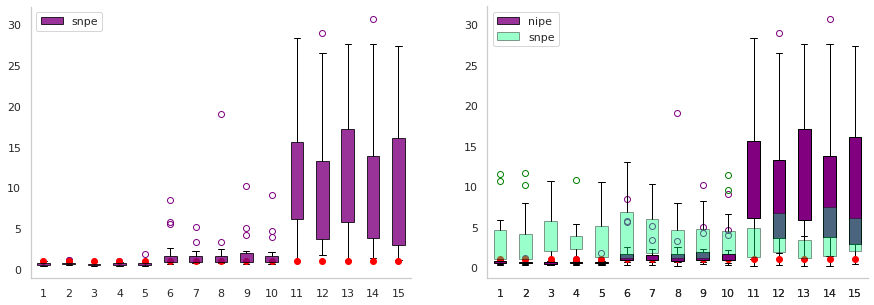

In [20]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')


figure_mosaic = """
AC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 5))

nipe = axes['C'].boxplot(nipe_noratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
                  )

nipe = axes['A'].boxplot(nipe_noratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
                  )


snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green', label='snpe'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
for b in nipe['boxes']:
    b.set_alpha(0.8)
    
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
    


axes['C'].legend([nipe['boxes'][0], snpe_c['boxes'][0]], ['nipe', 'snpe'], loc='upper left')
axes['A'].legend([nipe['boxes'][0]], [ 'snpe'], loc='upper left')
sns.despine()
sns.set_context('notebook')

NameError: name 'nipe_greater_ratio_array' is not defined

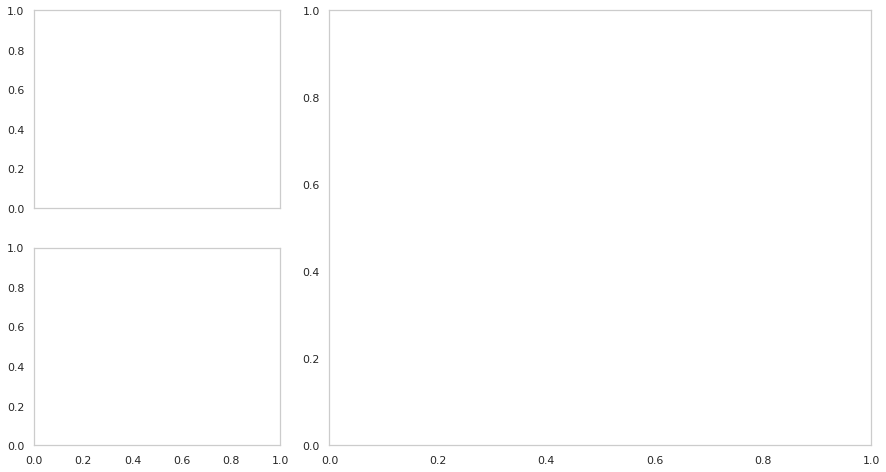

In [21]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

#nipe_box  = axes['A'].boxplot(nipe_noratio_array, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='lightblue', markeredgecolor='blue'),positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
#                                                                                 14, 15])
axes['A'].set(xticklabels=[])
#nipe_ratio_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
#                                                                                 14.1, 15.1])

nipe_greater = axes['A'].boxplot(nipe_greater_ratio_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(linewidth=0),            
            flierprops=dict(color='purple', markeredgecolor='purple'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])
axes['A'].set(xticklabels=[])


axes['A'].set_ylim(0,5)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='springgreen'), medianprops=dict(linewidth=0),flierprops=dict(color='green', markeredgecolor='green'),)
axes['B'].set_ylim(0,10)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box = axes['C'].boxplot(nipe_noratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='lightblue'),  flierprops=dict(color='lightblue', markeredgecolor='lightblue'),
                  positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 
                                                                                 14.9])


nipe_ratio_box = axes['C'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='blue'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
                                                                                 14.1, 15.1])

nipe_greater = axes['C'].boxplot(nipe_greater_ratio_array, medianprops = dict(linewidth=0),patch_artist=True, boxprops=dict(facecolor='purple'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])

for b in nipe_greater['boxes']:
    b.set_alpha(0.8)
    
for b in nipe_ratio_box['boxes']:
    b.set_alpha(0.8)

for b in nipe_box['boxes']:
    b.set_alpha(0.8)
    
for b in snpe_box['boxes']:
    b.set_alpha(0.4)
    
    
axes['C'].set(xticklabels=[])

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

    
axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
axes['C'].set_ylim(0,16)

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_greater['boxes'][0], ana_plot[0]], ['nipe budget3',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], nipe_ratio_box['boxes'][0],  nipe_greater['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe budget1', 'nipe budget2', 'nipe budget3','snpe', 'analytic'], loc='upper left')

In [78]:
nipe_array = torch.stack(([mean_list[i] for i in range(10)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(10)]), dim=1)

In [73]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

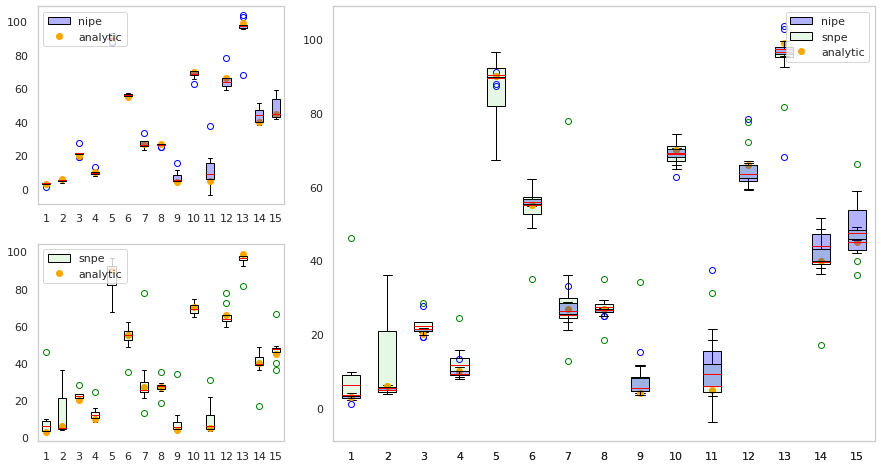

In [79]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')